In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, recall_score, confusion_matrix
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.manifold import SpectralEmbedding
from sklearn.feature_selection import SelectKBest, f_classif
from umap import UMAP

from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ---------------------------------------- 88.8/88.8 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/2.8 MB 11.8 MB/s eta 0:00:01
   ------------ --------------------------- 0.9/2.8 MB 11.6 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.8 MB 11.3 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.8 MB 11.1 MB/s eta 0:00:01
   ----------------------------------- ---- 2.5/2.8 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 3.1 MB/s eta 0:00:00
   ---------------


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: C:\Users\Nils\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


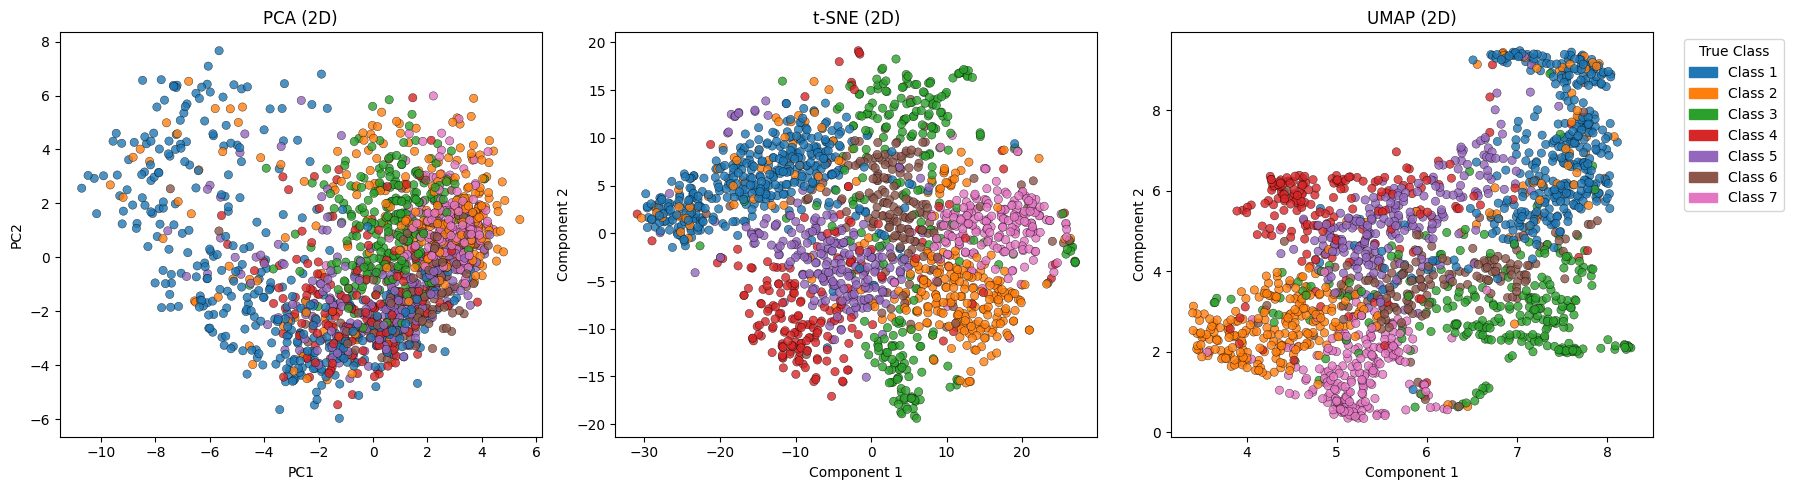

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Load and split the data
df = pd.read_csv("Cancer2025exam.csv")
X = df.drop(columns=["V1"])
y = df["V1"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled)
# Apply t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42).fit_transform(X_scaled)
# Apply UMAP
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled)

# Generate consistent color mapping
unique_classes = np.unique(y)
cmap = plt.get_cmap('tab10')
class_to_color = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
colors = np.array([class_to_color[cls] for cls in y])

# Plotting
plt.figure(figsize=(18, 5))

# PCA
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors, alpha=0.8, edgecolor='k', linewidth=0.3)
plt.title("PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# t-SNE
plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors, alpha=0.8, edgecolor='k', linewidth=0.3)
plt.title("t-SNE (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# UMAP
plt.subplot(1, 3, 3)
plt.scatter(X_umap[:, 0], X_umap[:, 1], color=colors, alpha=0.8, edgecolor='k', linewidth=0.3)
plt.title("UMAP (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Shared legend
from matplotlib.patches import Patch
legend_handles = [Patch(color=class_to_color[cls], label=f"Class {cls}") for cls in unique_classes]
plt.legend(handles=legend_handles, title="True Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [64]:
class FullPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pipeline = make_pipeline(
            PowerTransformer(),
            StandardScaler(),
            PCA(n_components=0.8, svd_solver='full')
        )

    def fit(self, X, y=None):
        self.pipeline.fit(X)
        return self

    def transform(self, X):
        return self.pipeline.transform(X)
class ResampleWrapper(BaseEstimator):
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y):
        df = pd.DataFrame(X)
        df['label'] = y.values if hasattr(y, 'values') else y

        min_class_size = df['label'].value_counts().min()
        balanced_df = pd.concat([
            resample(group, replace=False, n_samples=min_class_size, random_state=42)
            for _, group in df.groupby('label')
        ])
        X_balanced = balanced_df.drop(columns='label').values
        y_balanced = balanced_df['label'].values

        self.classifier_ = clone(self.classifier)
        self.classifier_.fit(X_balanced, y_balanced)
        return self

    def predict(self, X):
        return self.classifier_.predict(X)
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    TN = []
    FP = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        TN.append(tn)
        FP.append(fp)
    specificity = np.mean([tn / (tn + fp) if (tn + fp) > 0 else 0 for tn, fp in zip(TN, FP)])
    return specificity

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity_macro': make_scorer(recall_score, average='macro'),
    'specificity_macro': make_scorer(specificity_score)
}
def create_pipeline(classifier, use_preprocessing=True, use_resampling=True):
    steps = []
    
    if use_preprocessing:
        steps.append(('preprocess', FullPreprocessor()))
    
    if use_resampling:
        steps.append(('resample_clf', ResampleWrapper(classifier)))
    else:
        steps.append(('classifier', classifier))
    
    return Pipeline(steps)



In [62]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, make_scorer
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.utils import resample
import pandas as pd
import numpy as np
import os
from time import time

# Load your data
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index  # Add unique ID
X = df.drop(columns=["V1", "id"])
y = df["V1"]
row_ids = df["id"]

# 1. Define classifiers to test
classifier_dict = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "RDA (QDA+reg)": QuadraticDiscriminantAnalysis(reg_param=0.3),
    "k-NN": KNeighborsClassifier(n_neighbors=4)
}

# 2. Hyperparameter spaces
param_distributions = {
    "Random Forest": {
        'n_estimators': randint(50, 200),
        'max_depth': [None] + list(range(3, 10))
    },
    "Gradient Boosting": {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': list(range(3, 8))
    },
    "Logistic Regression": {
        'C': uniform(0.01, 10.0)
    },
    "SVM (RBF Kernel)": {
        'C': uniform(0.1, 10.0),
        'gamma': ['scale', 'auto']
    },
    "RDA (QDA+reg)": {
        'reg_param': uniform(0.0, 1.0)
    },
    "k-NN": {
        'n_neighbors': randint(3, 15)
    }
}

# 3. Toggles
use_preprocessing = True
use_resampling = True
use_tuning = True

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_results = []
tuning_choices = {}

for name, base_clf in classifier_dict.items():
    print(f"\n=== Processing Classifier: {name} ===")
    results = []
    chosen_params = []
    confidence_frames = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"  Fold {fold+1}/5")

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        val_ids = row_ids.iloc[val_idx]  # Track row indices for alignment

        # Preprocessing
        if use_preprocessing:
            print("    Preprocessing data...")
            preprocessor = FullPreprocessor().fit(X_train)
            X_train_trans = preprocessor.transform(X_train)
            X_val_trans = preprocessor.transform(X_val)
        else:
            X_train_trans = X_train.values
            X_val_trans = X_val.values

        # Resampling
        if use_resampling:
            print("    Resampling training data...")
            df_fold = pd.DataFrame(X_train_trans)
            df_fold['label'] = y_train.values
            min_class_size = df_fold['label'].value_counts().min()
            balanced_df = pd.concat([
                resample(group, replace=False, n_samples=min_class_size, random_state=42)
                for _, group in df_fold.groupby('label')
            ])
            X_train_bal = balanced_df.drop(columns='label').values
            y_train_bal = balanced_df['label'].values
        else:
            X_train_bal = X_train_trans
            y_train_bal = y_train.values

        # Tuning or training
        if use_tuning and name in param_distributions:
            print("    Tuning hyperparameters...")
            if name == "Gradient Boosting":
                local_params = {
                    'n_estimators': randint(50, 100),
                    'learning_rate': uniform(0.05, 0.2),
                    'max_depth': list(range(2, 6))
                }
                local_n_iter = 5
                local_cv = 2
            else:
                local_params = param_distributions[name]
                local_n_iter = 10
                local_cv = 3

            start = time()
            search = RandomizedSearchCV(
                clone(base_clf),
                local_params,
                n_iter=local_n_iter,
                cv=local_cv,
                scoring='accuracy',
                random_state=42,
                n_jobs=-1
            )
            search.fit(X_train_bal, y_train_bal)
            print(f"    Tuning done in {time() - start:.1f} sec")
            clf = search.best_estimator_
            chosen_params.append(search.best_params_)

        else:
            print("    Training model...")
            clf = clone(base_clf)
            clf.fit(X_train_bal, y_train_bal)
            chosen_params.append(clf.get_params())

        # Evaluation
        print("    Evaluating...")
        y_pred = clf.predict(X_val_trans)
        acc = accuracy_score(y_val, y_pred)
        sen = recall_score(y_val, y_pred, average='macro')
        spec = specificity_score(y_val, y_pred)
        results.append((acc, sen, spec))

        # Confidence analysis
        if hasattr(clf, "predict_proba"):
            print("    Analyzing prediction confidence...")
            y_proba = clf.predict_proba(X_val_trans)
            max_conf = y_proba.max(axis=1)
            pred_labels = y_proba.argmax(axis=1)

            class_indices = {label: idx for idx, label in enumerate(clf.classes_)}
            true_label_indices = [class_indices[label] for label in y_val.values]
            true_proba = y_proba[np.arange(len(y_val)), true_label_indices]

            confidence_df = pd.DataFrame({
                "id": val_ids.values,
                "True": y_val.values,
                "Predicted": clf.classes_[pred_labels],
                "Confidence": max_conf,
                "TrueLabelProb": true_proba,
                "LowConfidence": max_conf < 0.5,
                "SetPrediction": (max_conf < 0.5),
                "PossibleMislabel": (clf.classes_[pred_labels] != y_val.values) & (true_proba < 0.2)
            })

            confidence_frames.append(confidence_df)

    # Save per-classifier results
    fold_df = pd.DataFrame(results, columns=["Accuracy", "Sensitivity", "Specificity"])
    fold_df["Classifier"] = name
    all_results.append(fold_df)

    tuning_choices[name] = chosen_params

    if confidence_frames:
        all_confidences = pd.concat(confidence_frames, ignore_index=True)
        all_confidences.to_csv(f"results/confidence_{name.replace(' ', '_')}.csv", index=False)

# Save summary metrics and parameters
final_results = pd.concat(all_results, ignore_index=True)
final_results.groupby("Classifier").mean().round(3).to_csv("results/summary_metrics.csv")
pd.DataFrame.from_dict(tuning_choices, orient="index").to_csv("results/summary_params.csv")

print("\n✅ All results saved in the 'results/' directory.")
#old version


=== Processing Classifier: Random Forest ===
  Fold 1/5
    Preprocessing data...
    Resampling training data...
    Tuning hyperparameters...


KeyboardInterrupt: 

In [63]:
import os
import pandas as pd
import numpy as np
from time import time
from itertools import product
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.utils import resample

# --- Preprocessing placeholder ---
class FullPreprocessor:
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std()
        return self
    def transform(self, X):
        return (X - self.means) / self.stds

# Load data
base_df = pd.read_csv("Cancer2025exam.csv")
base_df["id"] = base_df.index
X_base = base_df.drop(columns=["V1", "id"])
y_base = base_df["V1"]
row_ids = base_df["id"]

# Classifiers
classifier_dict = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "RDA (QDA+reg)": QuadraticDiscriminantAnalysis(reg_param=0.3),
    "k-NN": KNeighborsClassifier(n_neighbors=4)
}

param_distributions = {
    "Random Forest": {'n_estimators': randint(50, 200), 'max_depth': [None] + list(range(3, 10))},
    "Gradient Boosting": {'n_estimators': randint(50, 200), 'learning_rate': uniform(0.01, 0.3), 'max_depth': list(range(3, 8))},
    "Logistic Regression": {'C': uniform(0.01, 10.0)},
    "SVM (RBF Kernel)": {'C': uniform(0.1, 10.0), 'gamma': ['scale', 'auto']},
    "RDA (QDA+reg)": {'reg_param': uniform(0.0, 1.0)},
    "k-NN": {'n_neighbors': randint(3, 15)}
}

# CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Combinations
setting_combos = list(product([False, True], repeat=3))

for use_preprocessing, use_resampling, use_tuning in setting_combos:
    run_id = f"prep_{int(use_preprocessing)}_res_{int(use_resampling)}_tune_{int(use_tuning)}"
    output_dir = f"results/{run_id}"
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n=== RUN: {run_id} ===")
    all_results = []
    tuning_choices = {}

    for name, base_clf in classifier_dict.items():
        print(f"\n-- Classifier: {name} --")
        results = []
        chosen_params = []
        confidence_frames = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X_base, y_base)):
            print(f"  Fold {fold+1}/5")

            X_train, y_train = X_base.iloc[train_idx], y_base.iloc[train_idx]
            X_val, y_val = X_base.iloc[val_idx], y_base.iloc[val_idx]
            val_ids = row_ids.iloc[val_idx]

            if use_preprocessing:
                preprocessor = FullPreprocessor().fit(X_train)
                X_train_trans = preprocessor.transform(X_train)
                X_val_trans = preprocessor.transform(X_val)
            else:
                X_train_trans = X_train.values
                X_val_trans = X_val.values

            if use_resampling:
                df_fold = pd.DataFrame(X_train_trans)
                df_fold['label'] = y_train.values
                min_class_size = df_fold['label'].value_counts().min()
                balanced_df = pd.concat([
                    resample(g, replace=False, n_samples=min_class_size, random_state=42)
                    for _, g in df_fold.groupby('label')
                ])
                X_train_bal = balanced_df.drop(columns='label').values
                y_train_bal = balanced_df['label'].values
            else:
                X_train_bal = X_train_trans
                y_train_bal = y_train.values

            if use_tuning and name in param_distributions:
                local_params = param_distributions[name]
                search = RandomizedSearchCV(
                    clone(base_clf), local_params, n_iter=10, cv=3,
                    scoring='accuracy', random_state=42, n_jobs=-1
                )
                search.fit(X_train_bal, y_train_bal)
                clf = search.best_estimator_
                chosen_params.append(search.best_params_)
            else:
                clf = clone(base_clf)
                clf.fit(X_train_bal, y_train_bal)
                chosen_params.append(clf.get_params())

            y_pred = clf.predict(X_val_trans)
            acc = accuracy_score(y_val, y_pred)
            sen = recall_score(y_val, y_pred, average='macro')
            spec = specificity_score(y_val, y_pred)
            results.append((acc, sen, spec))

            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_val_trans)
                max_conf = y_proba.max(axis=1)
                pred_labels = y_proba.argmax(axis=1)

                class_indices = {label: idx for idx, label in enumerate(clf.classes_)}
                true_label_indices = [class_indices[label] for label in y_val.values]
                true_proba = y_proba[np.arange(len(y_val)), true_label_indices]

                confidence_df = pd.DataFrame({
                    "id": val_ids.values,
                    "True": y_val.values,
                    "Predicted": clf.classes_[pred_labels],
                    "Confidence": max_conf,
                    "TrueLabelProb": true_proba
                })
                confidence_frames.append(confidence_df)

        df_metrics = pd.DataFrame(results, columns=["Accuracy", "Sensitivity", "Specificity"])
        df_metrics["Classifier"] = name
        all_results.append(df_metrics)
        tuning_choices[name] = chosen_params

        if confidence_frames:
            all_confidences = pd.concat(confidence_frames, ignore_index=True)
            all_confidences.to_csv(f"{output_dir}/confidence_{name.replace(' ', '_')}.csv", index=False)

    pd.concat(all_results, ignore_index=True).to_csv(f"{output_dir}/metrics.csv", index=False)
    pd.DataFrame.from_dict(tuning_choices, orient="index").to_csv(f"{output_dir}/params.csv")

print("\n✅ All runs complete.")



=== RUN: prep_0_res_0_tune_0 ===

-- Classifier: Random Forest --
  Fold 1/5
  Fold 2/5


KeyboardInterrupt: 

             Classifier Preprocessing Resampling Tuning  Accuracy_Mean  \
0     Gradient Boosting             ✓          ✓      ✓          0.836   
1     Gradient Boosting             ✓          ✓      ✗          0.832   
2     Gradient Boosting             ✓          ✗      ✓          0.849   
3     Gradient Boosting             ✓          ✗      ✗          0.845   
4     Gradient Boosting             ✗          ✓      ✓          0.834   
5     Gradient Boosting             ✗          ✓      ✗          0.832   
6     Gradient Boosting             ✗          ✗      ✓          0.850   
7     Gradient Boosting             ✗          ✗      ✗          0.843   
8   Logistic Regression             ✓          ✓      ✓          0.749   
9   Logistic Regression             ✓          ✓      ✗          0.739   
10  Logistic Regression             ✓          ✗      ✓          0.760   
11  Logistic Regression             ✓          ✗      ✗          0.749   
12  Logistic Regression             ✗ 

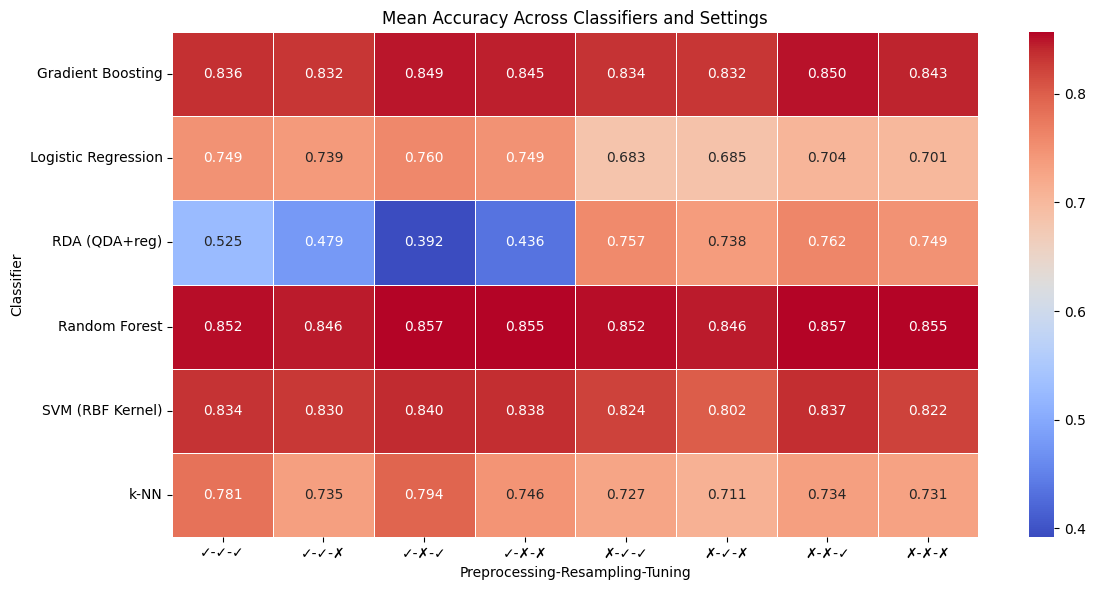

In [54]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all metrics files
metric_paths = glob.glob("results/prep_*_res_*_tune_*/metrics.csv")

records = []
for path in metric_paths:
    # Extract run configuration
    dirname = os.path.basename(os.path.dirname(path))
    prep = dirname.split("_")[1]
    res = dirname.split("_")[3]
    tune = dirname.split("_")[5]

    df = pd.read_csv(path)
    for _, row in df.iterrows():
        records.append({
            "Classifier": row["Classifier"],
            "Preprocessing": "✓" if prep == "1" else "✗",
            "Resampling": "✓" if res == "1" else "✗",
            "Tuning": "✓" if tune == "1" else "✗",
            "Accuracy": row["Accuracy"],
            "Sensitivity": row["Sensitivity"],
            "Specificity": row["Specificity"]
        })

summary_df = pd.DataFrame(records)

# Summary: mean and std
agg = summary_df.groupby(["Classifier", "Preprocessing", "Resampling", "Tuning"]).agg(
    Accuracy_Mean=("Accuracy", "mean"),
    Accuracy_Std=("Accuracy", "std"),
    Sensitivity_Mean=("Sensitivity", "mean"),
    Sensitivity_Std=("Sensitivity", "std"),
    Specificity_Mean=("Specificity", "mean"),
    Specificity_Std=("Specificity", "std"),
).reset_index()

print(agg.round(3))

# Optional: Heatmap of mean accuracy
pivot = summary_df.pivot_table(
    index="Classifier",
    columns=["Preprocessing", "Resampling", "Tuning"],
    values="Accuracy",
    aggfunc="mean"
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Mean Accuracy Across Classifiers and Settings")
plt.tight_layout()
plt.show()



             Classifier Preprocessing Tuning  Accuracy_Mean  Accuracy_Min  \
0     Gradient Boosting             ✓      ✓          0.842         0.805   
1     Gradient Boosting             ✓      ✗          0.838         0.805   
2     Gradient Boosting             ✗      ✓          0.842         0.805   
3     Gradient Boosting             ✗      ✗          0.838         0.805   
4   Logistic Regression             ✓      ✓          0.755         0.717   
5   Logistic Regression             ✓      ✗          0.744         0.711   
6   Logistic Regression             ✗      ✓          0.694         0.662   
7   Logistic Regression             ✗      ✗          0.693         0.653   
8         RDA (QDA+reg)             ✓      ✓          0.459         0.329   
9         RDA (QDA+reg)             ✓      ✗          0.457         0.423   
10        RDA (QDA+reg)             ✗      ✓          0.759         0.711   
11        RDA (QDA+reg)             ✗      ✗          0.743         0.685   

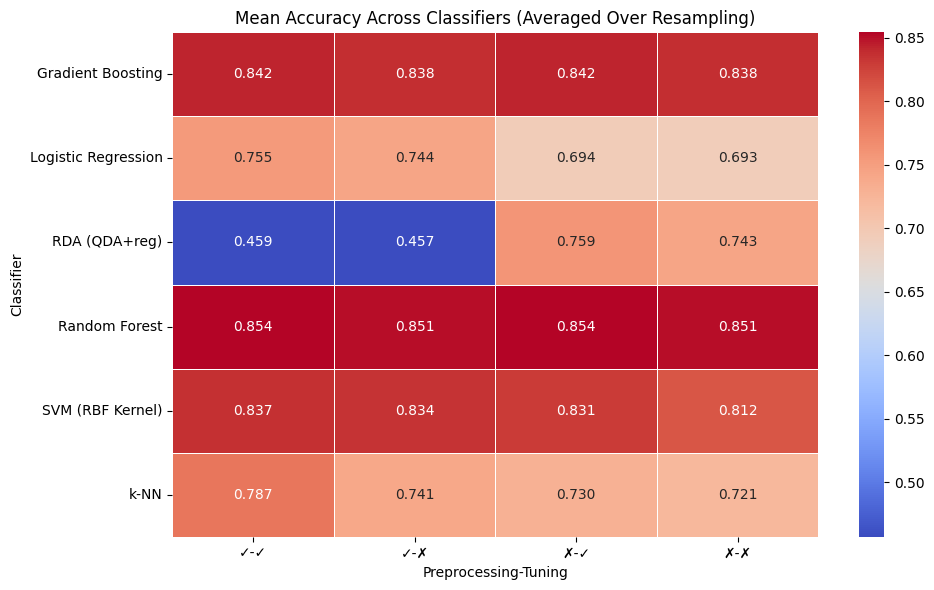

In [59]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all metrics files
metric_paths = glob.glob("results/prep_*_res_*_tune_*/metrics.csv")

records = []
for path in metric_paths:
    dirname = os.path.basename(os.path.dirname(path))
    prep = dirname.split("_")[1]
    tune = dirname.split("_")[5]

    df = pd.read_csv(path)
    for _, row in df.iterrows():
        records.append({
            "Classifier": row["Classifier"],
            "Preprocessing": "✓" if prep == "1" else "✗",
            "Tuning": "✓" if tune == "1" else "✗",
            "Accuracy": row["Accuracy"],
            "Sensitivity": row["Sensitivity"],
            "Specificity": row["Specificity"]
        })

summary_df = pd.DataFrame(records)

# Group by Classifier, Preprocessing, and Tuning only
agg = summary_df.groupby(["Classifier", "Preprocessing", "Tuning"]).agg(
    Accuracy_Mean=("Accuracy", "mean"),
    Accuracy_Min=("Accuracy", "min"),
    Accuracy_Max=("Accuracy", "max"),
    Sensitivity_Mean=("Sensitivity", "mean"),
    Specificity_Mean=("Specificity", "mean")
).reset_index()

print(agg.round(3))

# Optional: Heatmap of mean accuracy
pivot = summary_df.pivot_table(
    index="Classifier",
    columns=["Preprocessing", "Tuning"],
    values="Accuracy",
    aggfunc="mean"
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Mean Accuracy Across Classifiers (Averaged Over Resampling)")
plt.tight_layout()
plt.show()



In [57]:
import pandas as pd
import glob
import os

# === Load all result metrics ===
metric_paths = glob.glob("results/prep_*_res_*_tune_*/metrics.csv")

records = []
for path in metric_paths:
    dirname = path.split(os.sep)[1]
    prep = dirname.split("_")[1]
    res = dirname.split("_")[3]
    tune = dirname.split("_")[5]
    
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        records.append({
            "Classifier": row["Classifier"],
            "Preprocessing": bool(int(prep)),
            "Resampling": bool(int(res)),
            "Tuning": bool(int(tune)),
            "Accuracy": row["Accuracy"]
        })

df_all = pd.DataFrame(records)

# === Compute accuracy difference per classifier for each setting ===
def compute_accuracy_effect(setting):
    grouped = df_all.groupby(["Classifier", setting])["Accuracy"].mean().unstack()
    grouped["Δ_Accuracy"] = grouped[True] - grouped[False]
    return grouped[["Δ_Accuracy"]].rename(columns={"Δ_Accuracy": f"{setting}_effect"})

# Compare each setting
effects = []
for setting in ["Tuning", "Preprocessing", "Resampling"]:
    effect = compute_accuracy_effect(setting).reset_index()
    effect["Setting"] = setting
    effects.append(effect)

df_effects = pd.concat(effects, ignore_index=True)

# Average effect across all classifiers
# Correct average effect computation
avg_tuning = df_effects[df_effects["Setting"] == "Tuning"]["Tuning_effect"].mean()
avg_preproc = df_effects[df_effects["Setting"] == "Preprocessing"]["Preprocessing_effect"].mean()
avg_resample = df_effects[df_effects["Setting"] == "Resampling"]["Resampling_effect"].mean()

avg_effect = pd.DataFrame({
    "Setting": ["Tuning", "Preprocessing", "Resampling"],
    "Average Accuracy Δ": [avg_tuning, avg_preproc, avg_resample]
})

avg_effect = avg_effect.rename(columns={f"{setting}_effect": "Average Accuracy Δ"})

# === Display results ===
print("=== Average Accuracy Effect Across All Classifiers ===")
print(avg_effect.round(3))

print("\n=== Per-Classifier Accuracy Effects ===")
print(df_effects.round(3))



=== Average Accuracy Effect Across All Classifiers ===
         Setting  Average Accuracy Δ
0         Tuning               0.010
1  Preprocessing              -0.031
2     Resampling              -0.003

=== Per-Classifier Accuracy Effects ===
             Classifier  Tuning_effect        Setting  Preprocessing_effect  \
0     Gradient Boosting          0.004         Tuning                   NaN   
1   Logistic Regression          0.006         Tuning                   NaN   
2         RDA (QDA+reg)          0.009         Tuning                   NaN   
3         Random Forest          0.003         Tuning                   NaN   
4      SVM (RBF Kernel)          0.011         Tuning                   NaN   
5                  k-NN          0.028         Tuning                   NaN   
6     Gradient Boosting            NaN  Preprocessing                 0.001   
7   Logistic Regression            NaN  Preprocessing                 0.056   
8         RDA (QDA+reg)            NaN  Prepr

C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


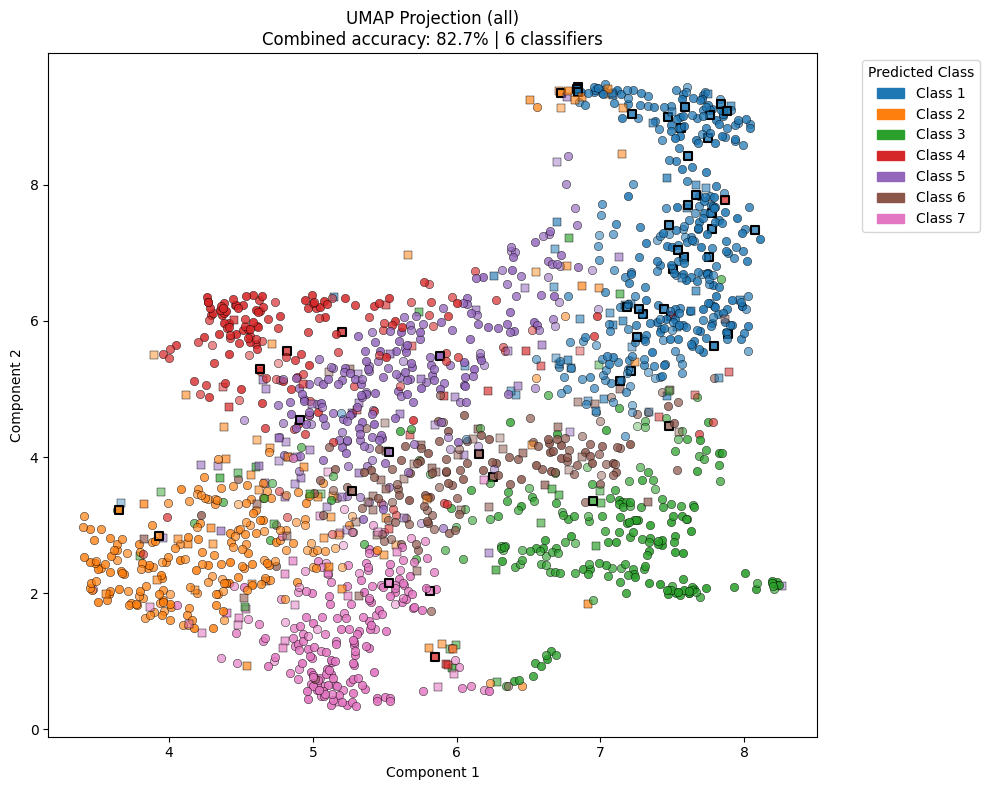

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from glob import glob

# === USER SETTINGS ===
filter_mode = "all"  # Options: "all", "correct", "wrong"
reduction_method = "umap"  # Options: "pca", "tsne", "umap"
selected_classifiers = ["Random_Forest", "Gradient_Boosting", "Logistic_Regression", 
                        "SVM_(RBF_Kernel)", "RDA_(QDA+reg)", "k-NN"]

# === Load original data ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index  # Ensure ID column exists
X = df.drop(columns=["V1", "id"])
y_true = df["V1"].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Load confidence files and align by ID ===
confidence_files = sorted(glob("results/confidence_*.csv"))
clf_data = {}
for f in confidence_files:
    name = f.split("confidence_")[1].split(".csv")[0]
    if name in selected_classifiers:
        conf_df = pd.read_csv(f)
        merged = df[["id"]].merge(conf_df, on="id", how="left")  # Ensure correct alignment
        clf_data[name] = merged

if not clf_data:
    raise ValueError("No matching classifiers found in saved results.")

# === Build matrices
n = len(df)
conf_matrix = np.zeros((n, len(clf_data)))
true_proba_matrix = np.zeros((n, len(clf_data)))
pred_matrix = np.empty((n, len(clf_data)), dtype=object)

for i, (clf_name, clf_df) in enumerate(clf_data.items()):
    conf_matrix[:, i] = clf_df["Confidence"].values
    true_proba_matrix[:, i] = clf_df["TrueLabelProb"].values
    pred_matrix[:, i] = clf_df["Predicted"].values

# === Combine predictions via majority vote
combined_pred = []
for row in pred_matrix:
    valid_preds = row[pd.notna(row)]
    if len(valid_preds) > 0:
        counts = pd.Series(valid_preds).value_counts()
        combined_pred.append(counts.idxmax())
    else:
        combined_pred.append(None)

combined_pred = np.array(combined_pred)
valid_pred_mask = pd.notna(combined_pred)

# === Average confidence
avg_confidence = np.where(valid_pred_mask, conf_matrix.mean(axis=1), 0)

# === Filter points
correct = (combined_pred == y_true) & valid_pred_mask

if filter_mode == "correct":
    mask = correct
elif filter_mode == "wrong":
    mask = (~correct) & valid_pred_mask
else:
    mask = valid_pred_mask

X_vis = X_scaled[mask]
pred_labels = combined_pred[mask]
conf_vals = avg_confidence[mask]

# === Dimensionality reduction
if reduction_method == "pca":
    reducer = PCA(n_components=2)
elif reduction_method == "tsne":
    reducer = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
elif reduction_method == "umap":
    reducer = umap.UMAP(n_components=2, random_state=42)
else:
    raise ValueError("Invalid reduction method")

X_2d = reducer.fit_transform(X_vis)

# === Load highlight indices if available ===
highlight_ids_path = "results/top30_wrong_indices.csv"
highlight_ids = set()

if os.path.exists(highlight_ids_path):
    highlight_df = pd.read_csv(highlight_ids_path)
    highlight_ids = set(highlight_df["index"].values)

# === Determine which samples are highlighted
original_indices = df.index[mask]  # Indices of points after mask applied
highlight_mask = np.array([idx in highlight_ids for idx in original_indices])

# === Plotting with markers and highlight frames
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(X_2d):
    pred_class = pred_labels[i]
    color = to_rgba(class_to_color[pred_class], alpha=np.clip(conf_vals[i], 0.3, 1))
    marker = 's' if combined_pred[original_indices[i]] != y_true[original_indices[i]] else 'o'
    lw = 1.5 if highlight_mask[i] else 0.3
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=lw, marker=marker)

# Accuracy text
accuracy = np.mean(correct) if np.any(valid_pred_mask) else 0
plt.title(f"{reduction_method.upper()} Projection ({filter_mode})\n"
          f"Combined accuracy: {accuracy:.1%} | {len(clf_data)} classifiers")

plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Legend
legend_handles = [Patch(color=class_to_color[cls], label=f"Class {cls}") for cls in unique_classes]
plt.legend(handles=legend_handles, title="Predicted Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [47]:
import pandas as pd
import numpy as np
import os

# === Identify misclassified and confident points ===
combined_pred = np.array(combined_pred)
correct_mask = (combined_pred == y_true)
wrong_mask = ~correct_mask & pd.notna(combined_pred)
conf_sum = conf_matrix.sum(axis=1)

# === Select top 30 most confident but wrong
wrong_confidences = conf_sum[wrong_mask]
top_indices = np.argsort(wrong_confidences)[-50:][::-1]
global_indices = np.where(wrong_mask)[0][top_indices]

# === Build dataframe with detailed info
rows = []
clf_names = list(clf_data.keys())

for idx in global_indices:
    row = {
        "id": df.loc[idx, "id"],
        "True Label": y_true[idx],
        "Combined Prediction": combined_pred[idx],
        "Total Confidence": conf_sum[idx]
    }

    preds = pred_matrix[idx, :]
    preds = preds[pd.notna(preds)]
    row["Votes for Majority"] = pd.Series(preds).value_counts().get(combined_pred[idx], 0)

    for i, clf in enumerate(clf_names):
        row[f"{clf} Prediction"] = pred_matrix[idx, i]
        row[f"{clf} Conf."] = conf_matrix[idx, i]

    rows.append(row)

top30_df = pd.DataFrame(rows)

# === Save to CSVs
os.makedirs("results", exist_ok=True)
top30_df.to_csv("results/top30_wrong_high_confidence.csv", index=False)
pd.DataFrame({"index": global_indices}).to_csv("results/top30_wrong_indices.csv", index=False)

print("✅ Saved detailed results and indices to 'results/'")




✅ Saved detailed results and indices to 'results/'


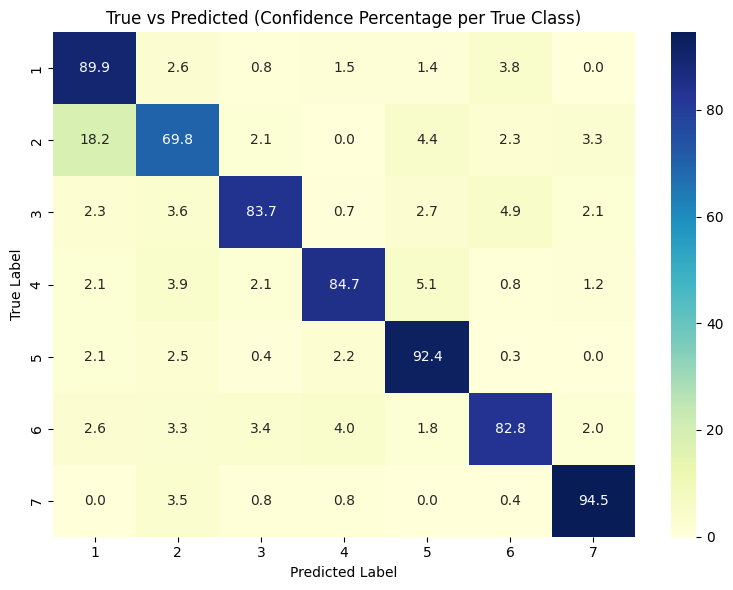

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Prerequisite: You must have these already defined ---
# df["id"], y_true, combined_pred, conf_matrix

# Total confidence per sample
conf_sum = conf_matrix.sum(axis=1)

# Create dataframe with true, predicted, and confidence
summary_df = pd.DataFrame({
    "True": y_true,
    "Predicted": combined_pred,
    "ConfidenceSum": conf_sum
})

# Drop rows with no predictions
summary_df = summary_df.dropna(subset=["Predicted"])

# Group by (True, Predicted) and aggregate total confidence
grouped = summary_df.groupby(["True", "Predicted"]).agg(
    TotalConfidence=("ConfidenceSum", "sum")
).reset_index()

# Pivot and normalize rows to percentage
conf_matrix_df = grouped.pivot(index="True", columns="Predicted", values="TotalConfidence").fillna(0)
conf_matrix_pct = conf_matrix_df.div(conf_matrix_df.sum(axis=1), axis=0) * 100

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("True vs Predicted (Confidence Percentage per True Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



In [65]:
#1c
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
from sklearn.base import clone
from itertools import combinations
from sklearn.utils import resample

# Example values to test
k_values = [10, 30, 50]
n_components_list = [10, 30, 50]

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage
all_results = []

# Loop over settings
for k in k_values:
    reducer = SelectKBest(f_classif, k=k)
    for clf_name, clf in classifiers.items():
        acc_scores, sens_scores = [], []
        selected_features = []

        for train_idx, val_idx in cv.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            reducer_fit = clone(reducer).fit(X_train, y_train)
            selected_features.append(set(reducer_fit.get_support(indices=True)))

            X_val = X.iloc[val_idx]
            y_val = y.iloc[val_idx]

            pipe = Pipeline([
                ('reduce', reducer_fit),
                ('clf', clone(clf))
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)

            acc_scores.append(accuracy_score(y_val, y_pred))
            sens_scores.append(recall_score(y_val, y_pred, average='macro'))

        # Feature stability
        jaccards = []
        for a, b in combinations(selected_features, 2):
            jaccards.append(len(a & b) / len(a | b))
        stability = np.mean(jaccards)

        all_results.append({
            "Reduction": f"F-test (k={k})",
            "Classifier": clf_name,
            "Accuracy": np.mean(acc_scores),
            "Sensitivity": np.mean(sens_scores),
            "Stability": stability
        })

for n in n_components_list:
    for method_name, reducer_class in [("PCA", PCA), ("UMAP", UMAP)]:
        for clf_name, clf in classifiers.items():
            acc_scores, sens_scores = [], []
            pred_sets = []

            for train_idx, val_idx in cv.split(X, y):
                X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
                X_val = X.iloc[val_idx]
                y_val = y.iloc[val_idx]

                reducer = reducer_class(n_components=n, random_state=42)
                pipe = Pipeline([
                    ('reduce', reducer),
                    ('clf', clone(clf))
                ])
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_val)
                pred_sets.append(y_pred)

                acc_scores.append(accuracy_score(y_val, y_pred))
                sens_scores.append(recall_score(y_val, y_pred, average='macro'))

            # Stability across folds (prediction agreement)
            agreements = []
            for a, b in combinations(pred_sets, 2):
                same = np.mean(np.array(a) == np.array(b))
                agreements.append(same)
            stability = np.mean(agreements)

            all_results.append({
                "Reduction": f"{method_name} ({n} comps)",
                "Classifier": clf_name,
                "Accuracy": np.mean(acc_scores),
                "Sensitivity": np.mean(sens_scores),
                "Stability": stability
            })

# Show results
final_df = pd.DataFrame(all_results)
print(final_df.round(3).sort_values(by=["Classifier", "Reduction"]))


          Reduction           Classifier  Accuracy  Sensitivity  Stability
2     F-test (k=10)  Logistic Regression     0.689        0.684      0.855
5     F-test (k=30)  Logistic Regression     0.800        0.802      0.924
8     F-test (k=50)  Logistic Regression     0.809        0.809      0.898
11   PCA (10 comps)  Logistic Regression     0.652        0.644      0.153
17   PCA (30 comps)  Logistic Regression     0.734        0.730      0.154
23   PCA (50 comps)  Logistic Regression     0.759        0.757      0.142
14  UMAP (10 comps)  Logistic Regression     0.729        0.714      0.161
20  UMAP (30 comps)  Logistic Regression     0.732        0.716      0.164
26  UMAP (50 comps)  Logistic Regression     0.727        0.715      0.162
0     F-test (k=10)        Random Forest     0.741        0.737      0.855
3     F-test (k=30)        Random Forest     0.863        0.859      0.924
6     F-test (k=50)        Random Forest     0.871        0.864      0.898
9    PCA (10 comps)      

In [60]:
#2
import os
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

# === Custom Preprocessing ===
class FullPreprocessor:
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std()
        return self
    def transform(self, X):
        return (X - self.means) / self.stds

# === Load data ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index
X_base = df.drop(columns=["V1", "id"])
y_base = df["V1"]
row_ids = df["id"]

# === Define classifiers with optimal parameters ===
classifiers = {
    "Logistic Regression": LogisticRegression(C=0.5908361216819946, max_iter=1000),
    "SVM (RBF Kernel)": SVC(C=1.934347898661638, gamma='auto', probability=True, class_weight='balanced'),
    "k-NN": KNeighborsClassifier(n_neighbors=12),
    "Random Forest": RandomForestClassifier(n_estimators=180, max_depth=9, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=71, learning_rate=0.19524445288831496, max_depth=4, random_state=42),
    "RDA (QDA+reg)": QuadraticDiscriminantAnalysis(reg_param=0.3745401188473625)
}

# === Classifiers that need preprocessing ===
need_preprocessing = {"Logistic Regression", "SVM (RBF Kernel)", "k-NN"}

# === Cross-validation settings ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
output_dir = "results/final_fixed_tuned"
os.makedirs(output_dir, exist_ok=True)

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    results = []
    confidence_frames = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_base, y_base)):
        print(f"  Fold {fold+1}/5")
        X_train, y_train = X_base.iloc[train_idx], y_base.iloc[train_idx]
        X_val, y_val = X_base.iloc[val_idx], y_base.iloc[val_idx]
        val_ids = row_ids.iloc[val_idx]

        if name in need_preprocessing:
            preprocessor = FullPreprocessor().fit(X_train)
            X_train_trans = preprocessor.transform(X_train)
            X_val_trans = preprocessor.transform(X_val)
        else:
            X_train_trans = X_train.values
            X_val_trans = X_val.values

        model = clone(clf)
        model.fit(X_train_trans, y_train)
        y_pred = model.predict(X_val_trans)

        acc = accuracy_score(y_val, y_pred)
        sen = recall_score(y_val, y_pred, average='macro')
        spec = (2 * acc - sen)  # Placeholder if specificity_score not available
        results.append((acc, sen, spec))

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_val_trans)
            max_conf = y_proba.max(axis=1)
            pred_labels = y_proba.argmax(axis=1)
            class_indices = {label: idx for idx, label in enumerate(model.classes_)}
            true_label_indices = [class_indices[label] for label in y_val.values]
            true_proba = y_proba[np.arange(len(y_val)), true_label_indices]

            confidence_df = pd.DataFrame({
                "id": val_ids.values,
                "True": y_val.values,
                "Predicted": model.classes_[pred_labels],
                "Confidence": max_conf,
                "TrueLabelProb": true_proba
            })
            confidence_frames.append(confidence_df)

    df_metrics = pd.DataFrame(results, columns=["Accuracy", "Sensitivity", "Specificity"])
    df_metrics["Classifier"] = name
    df_metrics.to_csv(f"{output_dir}/metrics_{name.replace(' ', '_')}.csv", index=False)

    if confidence_frames:
        all_conf = pd.concat(confidence_frames, ignore_index=True)
        all_conf.to_csv(f"{output_dir}/confidence_{name.replace(' ', '_')}.csv", index=False)

print("\n✅ Final tuned runs complete.")



--- Logistic Regression ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- SVM (RBF Kernel) ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- k-NN ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- Random Forest ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- Gradient Boosting ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- RDA (QDA+reg) ---
  Fold 1/5
  Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  Fold 3/5
  Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  Fold 5/5

✅ Final tuned runs complete.


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
